# Imports

In [1]:
# Imports
import pickle
import numpy as np
from matplotlib.pyplot import cm
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'code' 
if module_path not in sys.path:
    sys.path.append(module_path)
    
np.set_printoptions(threshold=sys.maxsize)


# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
def ModeMask(tf,ma,re):
    '''
    Creates an array that parallels the bouts in tf giving the behavioral mode for every state
    0=home,1=drink,2=explore
    '''
    cl=SplitModeClips(tf,ma,re=True) # split the trajectory into mode clips
    ex=[np.zeros(len(b)) for b in tf.no] # list of arrays, one for each bout
    for c in cl: # for each clip
        ex[c[0]][c[1]:c[1]+c[2]]=c[3] # mark the states in the clip with the mode
    return ex

In [3]:
def TranslLevelsLR(ma):
    '''
    discriminate by level and whether an L or an R node
    '''
    tra=np.zeros(2**(ma.le+1)-1,dtype=int) # number of node values
    tra[0]=0 # nodes level 0
    for k in range(1,ma.le+1): # nodes level 1,...
        for j in range(2**k-1,2**(k+1)-1):
            tra[j]=2*k-1+StepType(ma.pa[j],j,ma) # This distinguishes L from R nodes
    return tra

In [49]:
def FixMarkovTest3(da,mk,pr,ma,tr=None):
    '''
    Fixed depth Markov chain, testing
    da = data
    mk = mask applied to action, Boolean
    pr = probability array
    ma = maze
    tr = translation array for node numbers to states
    '''
    if tr is not None:
        st=tr[da] # translated state numbers
    else:
        st=da # no translation
    sh=pr.shape # shape of probability array
    de=len(sh)-1 # depth of history
    ac=np.array([-1]+[StepType2(da[j-1],da[j],ma) for j in range(1,len(da))]) # forward actions
    print()
    hi=np.array([-1]+[StepType3(da[j-1],da[j],ma) for j in range(1,len(da))]) # history actions
    pt=[] # predicted probabilities for the observed action
    for i in range(de,len(da)): # i points to the action to be predicted
        if mk[i]:
            x=tuple(hi[i-de+1:i]) # start array pointer with history of preceding de-1 reverse actions
            x+=(st[i-1],) # add the most recent state
            pt+=[pr[x][ac[i]]] # add probability for the observed action to the list
            
    
    ce=-np.sum(np.log(pt))/len(pt)/np.log(2) # cross-entropy
    return ce

In [50]:
def FixMarkovTrain3(da,mk,de,ma,tr=None):
    '''
    Fixed depth Markov chain, training
    No restriction on nodes except as specified by mk
    Collects counts for all combinations of history-action
    da = data
    mk = mask applied to action, Boolean
    de = depth of history
    ma = maze
    tr = translation array for node numbers to states
    '''
    if tr is not None:
        nt=np.max(tr)+1 # number of values for states
        st=tr[da] # translated state numbers
    else:
        nt=2**(ma.le+1)-1 # number of possible nodes, rightmost symbol in history is current node
        st=da # no translation
    sh=(3,)*(de-1)+(nt,)+(3,) # shape of counts array
    co=np.zeros(sh) # counts of history-action combinations
    ac=np.array([-1]+[StepType2(da[j-1],da[j],ma) for j in range(1,len(da))]) # forward actions
    hi=np.array([-1]+[StepType3(da[j-1],da[j],ma) for j in range(1,len(da))]) # history actions
    for i in range(de,len(da)): # i points to the action to be predicted
        if mk[i]:
            x=tuple(hi[i-de+1:i]) # start array pointer with history of preceding de-1 reverse actions
            x+=(st[i-1],) # add the most recent state
            co[x][ac[i]]+=1 # increase count for that action-history combination
    return co

In [52]:
def MarkovFit3(tf,ma,var=True,tju=True,exp=True,rew=True,seg=5,train=False,transl=None):
    '''
    Performs a Markov chain fit to predict actions in the trajectory tf on maze ma.
    Fit is restricted to T-junctions not including 0
    var = variable history depth?
    tju = actions at T-junctions only?
    exp = actions in "explore" mode only?
    rew = animal rewarded (relevant only if exp==True)
    seg = number of segments for testing 
    train = evaluate on training set?
    transl = array to convert node numbers into a reduced set of state numbers
    '''
    if exp:
        ex=ModeMask(tf,ma,rew) # one array for each bout marking states with mode = 0,1,2
    if var:
        par=np.array([2,3,5,10,20,40,80,160,320,640]) # min counts for the variable history
    else:
        par=np.array([1,2,3,4,5,6]) # fixed depths 
    hi=np.zeros(len(par)) # to store the avg history string length
    ce=np.zeros(len(par)) # to store the cross entropy
    for i in range(seg):
        dte=np.concatenate([b[:-2,0] for b in tf.no[i::seg]]) # test states
        mte=np.array([False]+[True,]*(len(dte)-1)) # mask for testing, all actions OK except first
        dtr=np.concatenate([b[:-2,0] for j in range(seg) for b in tf.no[j::seg] if j!=i]) # train states
        mtr=np.array([False]+[True,]*(len(dtr)-1)) # mask for training, all actions OK except first
        if tju: # restrict to actions taken from a T-junction, incl node 0
            mtr[np.where(dtr[:-1]>62)[0]+1]=False # mask for training, eliminate end nodes
            mte[np.where(dte[:-1]>62)[0]+1]=False # mask for testing, eliminate end nodes
        if exp: # restrict to actions taken to an explore state
            exe=np.concatenate([e[:-2] for e in ex[i::seg]]) # test mode
            exr=np.concatenate([e[:-2] for j in range(seg) for e in ex[j::seg] if j!=i]) # train mode
            mte[np.where(exe!=2)[0]]=False # limit the test mask to explore mode
            mtr[np.where(exr!=2)[0]]=False # limit the train mask to explore mode
        for j,k in enumerate(par):
            if var:
                co,le=VarMarkovTrain3(dtr,mtr,k,ma,transl)                
                hi[j]+=np.sum(le*np.arange(len(le)))/np.sum(le)+1 # mean history length
            else:
                co=FixMarkovTrain3(dtr,mtr,k,ma,transl)
                hi[j]+=k # history length
            su=np.sum(co,axis=-1).reshape(co.shape[:-1]+(1,)) # sum of counts over actions for each history
            pr=(co+1)/(su+3) # smoothed estimator of probability (note at node 0 there are just 2 options)
            print("pr: ", pr)
            if train:
                ce[j]+=FixMarkovTest3(dtr,mtr,pr,ma,transl) # evaluate on same as training data
            else:
                ce[j]+=FixMarkovTest3(dte,mte,pr,ma,transl) # evaluate on testing data
    hi/=seg
    ce/=seg
    si=np.argsort(hi) # sort by history length
    return hi[si],ce[si]

In [7]:
ma=NewMaze(6)

In [8]:
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze
AllNames=RewNames+UnrewNames

### Playing


[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [16, 17, 18, 19], [20, 21, 22, 23], [24, 25, 26, 27], [28, 29, 30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [50, 51], [52, 53], [54, 55], [56, 57], [58, 59], [60, 61], [62, 63], [64, 65], [66, 67], [68, 69], [70, 71], [72, 73], [74, 75], [76, 77], [78, 79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [154], [155], [156], [157], [158], [159], [160], [161], [162], [163], [164], [165], [166], [167], [168], [169], [170], [171], [17

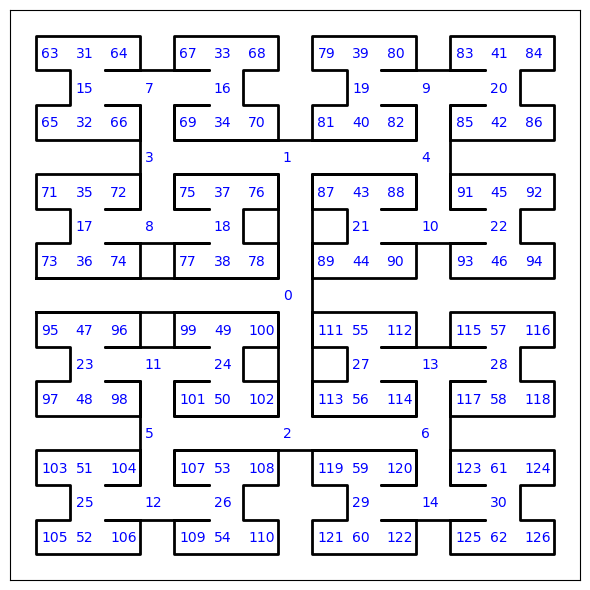

In [6]:
PlotMazeNodes(ma)
print(ma.ru)

In [42]:

terminals = np.arange(63,127)
terminal_mat = [[0,0,1],
                [0,0,0],
                [0,0,0]]

def reinit(beta):

    sta=TransMatrix(ma) # array of nodes connected to each node as such: index = parent node, [level, left child, right child]

    sta2=deepcopy(sta)
    for i in range(len(sta2)):
        sta2[i][0]=i
    
    E=np.ones((len(ma.ru),3,3)) # 3D array containing transition probability depending on 2-string as follows:
    # node i
    # [[left, right, parent] From parent
    #  [left, right, parent] From left
    #  [left, right, parent]] From right
    
    E[terminals] = 0

    exp_beta_E=np.exp(E * beta)
    policy=np.divide(exp_beta_E, exp_beta_E.sum(axis=2,keepdims=True), out=np.zeros_like(exp_beta_E), where=exp_beta_E.sum(axis=2,keepdims=True)!=0)
    policy[terminals] = terminal_mat
    
    return E,policy,sta



In [44]:
print(TransMatrix(ma))

[[127   1   2]
 [  0   3   4]
 [  0   6   5]
 [  1   8   7]
 [  1   9  10]
 [  2  12  11]
 [  2  13  14]
 [  3  15  16]
 [  3  18  17]
 [  4  19  20]
 [  4  22  21]
 [  5  23  24]
 [  5  26  25]
 [  6  27  28]
 [  6  30  29]
 [  7  32  31]
 [  7  33  34]
 [  8  36  35]
 [  8  37  38]
 [  9  40  39]
 [  9  41  42]
 [ 10  44  43]
 [ 10  45  46]
 [ 11  48  47]
 [ 11  49  50]
 [ 12  52  51]
 [ 12  53  54]
 [ 13  56  55]
 [ 13  57  58]
 [ 14  60  59]
 [ 14  61  62]
 [ 15  63  64]
 [ 15  66  65]
 [ 16  67  68]
 [ 16  70  69]
 [ 17  71  72]
 [ 17  74  73]
 [ 18  75  76]
 [ 18  78  77]
 [ 19  79  80]
 [ 19  82  81]
 [ 20  83  84]
 [ 20  86  85]
 [ 21  87  88]
 [ 21  90  89]
 [ 22  91  92]
 [ 22  94  93]
 [ 23  95  96]
 [ 23  98  97]
 [ 24  99 100]
 [ 24 102 101]
 [ 25 103 104]
 [ 25 106 105]
 [ 26 107 108]
 [ 26 110 109]
 [ 27 111 112]
 [ 27 114 113]
 [ 28 115 116]
 [ 28 118 117]
 [ 29 119 120]
 [ 29 122 121]
 [ 30 123 124]
 [ 30 126 125]
 [ 31  -1  -1]
 [ 31  -1  -1]
 [ 32  -1  -1]
 [ 32  -1 

In [10]:
reinit()

TypeError: reinit() missing 1 required positional argument: 'beta'

In [43]:
def updateEAndPolicy(E,policy,state0,action0,value1,beta,gamma,eta):
    value0 = E[state0[0]][state0[1]][action0]
    E[state0[0]][state0[1]][action0] += eta * (-value0 + gamma * value1)
    exp_beta_E=np.exp(E * beta)
    policy=np.divide(exp_beta_E, exp_beta_E.sum(axis=2,keepdims=True), out=np.zeros_like(exp_beta_E), where=exp_beta_E.sum(axis=2,keepdims=True)!=0)
    policy[terminals] = terminal_mat
    return E,policy

In [12]:
def chooseAction(policy, state):
    return int(np.random.choice(3,1,p=policy[state[0]][state[1]])[0])

In [13]:
def goModel(nbouts, E, policy, sta, beta,gamma,eta):
    home = False
    hist = []
    for i in range(nbouts):
        hist.append([])
        home=False
        state0 = (0,0)
        action0 = chooseAction(policy,state0)
        hist[i].append((state0,action0))
        while not home:
            state1_node = sta[state0[0]][action0]
            if state1_node == 127:
                home=True
            else:
                state1 = (state1_node,np.where(sta[state1_node]==state0[0])[0][0])
                action1 = chooseAction(policy,state1)
                value1 = E[state1[0]][state1[1]][action1]
                E,policy = updateEAndPolicy(E,policy,state0,action0,value1,beta,gamma,eta)
                state0 = state1
                action0 = action1

            hist[i].append((state0,action0))
    return E, policy, hist

In [14]:
# MAIN ACTIONS 1

eta=0.1
gamma=0.9

nbouts = 100
betas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
bhist = np.ndarray(shape=(10,2), dtype=object)
bhist[:,0] = betas
for j,beta in enumerate(betas):
    E,policy,sta = reinit(beta)
    E,policy,hist = goModel(nbouts,E,policy,sta,beta,gamma,eta)
    bhist[j,1] = hist
print(bhist)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
# Code from NewNodesMerge3 in MM_Traj_Utils
def NewNodes(hist,le):
    en=list(range(2**le-1,2**(le+1)-1)) # list of node numbers in level le
    
    hist_states = []
    for x in hist:
        for t in x:
            hist_states.append(t[0][0])
    
    ce=np.array(hist_states) # concatenate all the bouts, only the nodes, not the times
    ei=np.where(np.isin(ce,en))[0] # index of all the desired node states
    
    if len(ei)>0: # if there is at least one state
        cn=np.copy(ce[ei]) # only the desired nodes
        lc=len(cn) # number of desired nodes encountered
        c=np.array([2,3,6,10,18,32,56,100,180,320,560,1000,1800,3200,5600,10000]) # window width in nodes
        c=c[np.where(c<lc)] # use only those shorter than full length
        c=np.append(c,lc) # add full length as last value
        n=[np.average(np.array([len(set(cn[j:j+c1])) for j in range(0,lc-c1+1,(lc-c1)//(lc//c1)+1)])) for c1 in c]
            # average number of distinct nodes in slightly overlapping windows of size w 
    else:
        w=np.array([]); c=np.array([]); n=np.array([])
    wcn=[np.array([]),c,n]
    return wcn

[[5.00000000e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00]
 [2.80392157e-01 3.38158275e-01 9.85162233e-01 1.00000000e+00]
 [6.07843137e-02 6.36474236e-01 9.41089253e-01 1.00000000e+00]
 [1.66666667e-01 8.66025404e-01 8.66025404e-01 1.00000000e+00]
 [3.86274510e-01 9.84086337e-01 7.67362681e-01 1.00000000e+00]
 [6.13725490e-01 9.84086337e-01 6.41213315e-01 1.00000000e+00]
 [8.33333333e-01 8.66025404e-01 5.00000000e-01 1.00000000e+00]
 [1.00000000e+00 6.36474236e-01 3.38158275e-01 1.00000000e+00]
 [1.00000000e+00 3.38158275e-01 1.71625679e-01 1.00000000e+00]
 [1.00000000e+00 1.22464680e-16 6.12323400e-17 1.00000000e+00]]


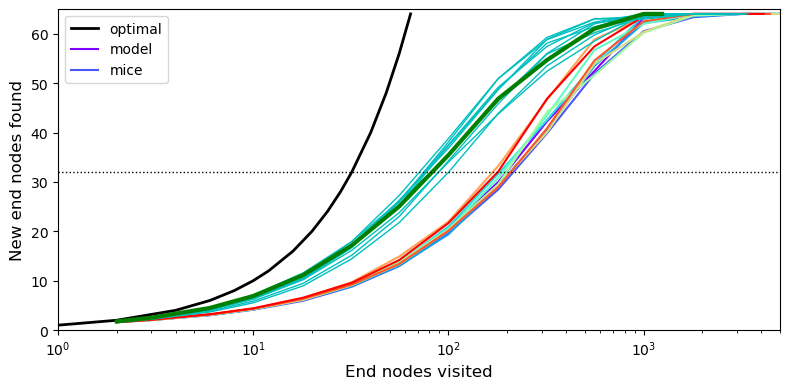

In [54]:
le=6 # End Nodes

x=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64],
y=[1,2,4,6,8,10,12,16,20,24,28,32,40,48,56,64], 
ax=plot(x,y,figsize=(8,4),fmts=['k-']);

color = cm.rainbow(np.linspace(0, 1, 10))
print(color)

for i,row in enumerate(bhist):
    wcn = NewNodes(row[1],le)
    x=wcn[1]
    y=wcn[2]
    plt.plot(x,y,c=color[i] ,axes=ax)



for i,nickname in enumerate(UnrewNamesSub):
    with open('outdata/'+nickname+'-Modes1', 'rb') as f:
        nn1,nf1,tr1,wcn=pickle.load(f)
    x=wcn[1,:]
    y=wcn[2,:]
    plot(x,y,fmts=['c-'],linewidth=1,axes=ax)
for i,nickname in enumerate(['B1']):
    with open('outdata/'+nickname+'-Modes1', 'rb') as f:
        nn1,nf1,tr1,wcn=pickle.load(f)
    x=wcn[1,:]
    y=wcn[2,:]
    plot(x,y,fmts=['g-'],linewidth=3,axes=ax)
x=[1,20000]
y=[32,32]
plot(x,y,axes=ax,fmts=['k:'],linewidth=1,
     xscale='log',
     xlim=[1,5000],ylim=[0,65],
     xlabel='End nodes visited',
     ylabel='New end nodes found',
     legend=['optimal','model','mice']
);

In [53]:
# Single animal
tra = TranslLevelsLR(ma)
for nickname in ['B1']:
    tf=LoadTraj(nickname+'-tf')
    if nickname=='C7': # patch over the bad bouts in C7
        good=list(range(68))+list(range(69,83))+list(range(85,len(tf.no)))
        tf.no=[tf.no[i] for i in good]
    rew=nickname in RewNames # whether animal is rewarded
    hif,cef=MarkovFit3(tf,ma,var=False,tju=True,exp=True,rew=rew,seg=5,train=False,transl=tra)
    #hiv,cev=MarkovFit3(tf,ma,var=True,tju=True,exp=True,rew=rew,seg=5,train=False,transl=tra)
np.min(cef)
#,np.min(cev)

pr:  [[0.66666667 0.32183908 0.01149425]
 [0.39694656 0.41221374 0.19083969]
 [0.2137931  0.36551724 0.42068966]
 [0.17479675 0.42682927 0.39837398]
 [0.45205479 0.26027397 0.28767123]
 [0.17553191 0.35106383 0.47340426]
 [0.4246988  0.27108434 0.30421687]
 [0.28782895 0.44572368 0.26644737]
 [0.39779006 0.25414365 0.3480663 ]
 [0.15939279 0.35294118 0.48766603]
 [0.2960688  0.17936118 0.52457002]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]

pr:  [[[0.33333333 0.33333333 0.33333333]
  [0.36666667 0.6        0.03333333]
  [0.6        0.36666667 0.03333333]
  [0.21428571 0.77380952 0.01190476]
  [0.76415094 0.21698113 0.01886792]
  [0.17605634 0.78169014 0.04225352]
  [0.69375    0.25625    0.05      ]
  [0.1902439  0.70731707 0.10243902]
  [0.72018349 0.18807339 0.09174312]
  [0.07522936 0.5266055  0.39816514]
  [0.39366516 0.15158371 0.45475113]
  [0.33333333 0.33333333 0.33333333]
  [0.33333333 0.33333333 0.33333333]]

 [[0.25925926 0.7037037  0.03703704]


pr:  [[[[[[0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.21052632 0.68421053 0.10526316]
     [0.7037037  0.11111111 0.18518519]
     [0.05228758 0.66666667 0.28104575]
     [0.39473684 0.15789474 0.44736842]
     [0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]]

    [[0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.33333333 0.33333333 0.33333333]
     [0.2        0.4        0.4       ]
     [0.16666667 0.66666667 0.16666667]
     [0.33333333 0.38888889 0.27777778]
     [0.55769231 0.34615385 0.09615385]
     [0.19354839 0.38709677 0.41935484]
     [0.19230769 0.16666667 0.64102564]
     [0.33333333 0.33333333 0.333

pr:  [[[[[[[0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.03960396 0.75247525 0.20792079]
      [0.34375    0.1875     0.46875   ]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]]

     [[0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.33333333 0.33333333 0.33333333]
      [0.25       0.25       0.5       ]
      [0.16666667 0.66666667 0.16666667]
      [0.4        0.3        0.3       ]
      [0.56410256 0.35897436 0.07692308]
      [0.28571429 0.28571429 0.42857143]
      [0.23404255 0.21276596 0.55319149]
      [0.

pr:  [[0.68421053 0.30526316 0.01052632]
 [0.37142857 0.41428571 0.21428571]
 [0.18666667 0.38666667 0.42666667]
 [0.16528926 0.40909091 0.42561983]
 [0.46153846 0.27935223 0.25910931]
 [0.19804401 0.34963325 0.45232274]
 [0.3982808  0.28080229 0.32091691]
 [0.28184713 0.43471338 0.28343949]
 [0.41140025 0.2527881  0.33581165]
 [0.15281501 0.3458445  0.50134048]
 [0.29542921 0.20401338 0.50055741]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]

pr:  [[[0.33333333 0.33333333 0.33333333]
  [0.32835821 0.62686567 0.04477612]
  [0.4516129  0.48387097 0.06451613]
  [0.20987654 0.77777778 0.01234568]
  [0.76521739 0.2173913  0.0173913 ]
  [0.23376623 0.74025974 0.02597403]
  [0.66463415 0.28658537 0.04878049]
  [0.18894009 0.70967742 0.10138249]
  [0.73640167 0.17991632 0.08368201]
  [0.10169492 0.49152542 0.40677966]
  [0.39177489 0.18181818 0.42640693]
  [0.33333333 0.33333333 0.33333333]
  [0.33333333 0.33333333 0.33333333]]

 [[0.21875    0.75       0.03125   ]


1.2504406427443011

In [22]:
def FlattenHist(hist):
    fhist = []
    for x in hist:
        for t in x:
            fhist.append(t[0][0])
    return fhist

In [29]:
# Main ACTIONS 2
beta=0.1
eta=0.1
gamma=0.9
nbouts = 10
E,policy,sta = reinit(beta)
E,policy,hist = goModel(nbouts,E,policy,sta,beta,gamma,eta)
print(hist)
fhist = FlattenHist(hist)
print(fhist)
print(policy)


[[((0, 0), 2), ((2, 0), 0), ((0, 2), 1), ((1, 0), 1), ((3, 0), 2), ((7, 0), 0), ((3, 2), 2), ((7, 0), 2), ((16, 0), 2), ((34, 0), 2), ((69, 0), 0), ((34, 2), 0), ((16, 2), 1), ((33, 0), 0), ((16, 1), 0), ((7, 2), 2), ((16, 0), 1), ((33, 0), 2), ((68, 0), 0), ((33, 2), 2), ((68, 0), 0), ((33, 2), 1), ((67, 0), 0), ((33, 1), 0), ((16, 1), 2), ((34, 0), 1), ((70, 0), 0), ((34, 1), 0), ((16, 2), 1), ((33, 0), 0), ((16, 1), 2), ((34, 0), 0), ((16, 2), 1), ((33, 0), 2), ((68, 0), 0), ((33, 2), 0), ((16, 1), 0), ((7, 2), 1), ((15, 0), 1), ((32, 0), 2), ((65, 0), 0), ((32, 2), 2), ((65, 0), 0), ((32, 2), 0), ((15, 1), 1), ((32, 0), 0), ((15, 1), 2), ((31, 0), 2), ((64, 0), 0), ((31, 2), 1), ((63, 0), 0), ((31, 1), 1), ((63, 0), 0), ((31, 1), 1), ((63, 0), 0), ((31, 1), 2), ((64, 0), 0), ((31, 2), 0), ((15, 2), 1), ((32, 0), 0), ((15, 1), 2), ((31, 0), 0), ((15, 2), 0), ((7, 1), 0), ((3, 2), 1), ((8, 0), 2), ((17, 0), 2), ((35, 0), 1), ((71, 0), 0), ((35, 1), 0), ((17, 2), 0), ((8, 2), 2), ((17

In [40]:
def Test(da,mk,pr,ma):
    st=da
    ac=np.array([-1]+[StepType2(da[j-1],da[j],ma) for j in range(1,len(da))]) # forward actions
    print(ac)
    for i in range(1,len(da)): # i points to the action to be predicted
        if mk[i]:
            x=st[i-1] # add the most recent state
            #pt+=[pr[x][ac[i]]] # add probability for the observed action to the list
    #ce=-np.sum(np.log(pt))/len(pt)/np.log(2) # cross-entropy
    #return ce

In [41]:
# Single animal
seg = 5
rew = True
tra = TranslLevelsLR(ma)
for nickname in ['B1']:
    tf=LoadTraj(nickname+'-tf')
    #hif,cef=MarkovFit3(tf,ma,var=False,tju=True,exp=True,rew=rew,seg=5,train=False,transl=tra)
    #hiv,cev=MarkovFit3(tf,ma,var=True,tju=True,exp=True,rew=rew,seg=5,train=False,transl=tra)
ex=ModeMask(tf,ma,rew) # one array for each bout marking states with mode = 0,1,2
dte=np.concatenate([b[:-2,0] for b in tf.no[i::seg]]) # test states
mte=np.array([False]+[True,]*(len(dte)-1)) # mask for testing, all actions OK except first
mte[np.where(dte[:-1]>62)[0]+1]=False # mask for testing, eliminate end nodes
exe=np.concatenate([e[:-2] for e in ex[i::seg]]) # test mode
mte[np.where(exe!=2)[0]]=False # limit the test mask to explore mode
print(dte)
print(policy)
Test(dte,mte,policy,ma)


[  0   1   4  10  22  46  94  46  94  46  22  45  92  45  91  45  22  10
  21  44  90  44  89  44  21  43  87  43  88  43  87  43  21  10  22  45
  22  46  94  46  93  46  22  10  21  44  89  44  90  44  89  44  21  43
  87  43  88  43  21  10  22  45  22  46  22  45  92  45  91  45  22  46
  93  46  22  10  21  44  90  44  21  43  87  43  87  43  21  44  89  44
  90  44  21  43  88  43  21  10   4   9  19  40  19  39  79  39  19   9
  20  42  86  42  86  42  85  42  85  42  20   9  19  39  19  39  80  39
  19  40  81  40  82  40  19   9  20  41  83  41  84  41  20  42  86  42
  85  42  20   9  19  39  19  39  79  39  80  39  19  39  79  39  19  40
  81  40  82  40  19   9  20  42  85  42  20   9   4  10  22  45  22  10
  21  44  90  44  21  10   4   9  19  40  19  39  19   9   4  10  22  46
  94  46  93  46  22  10  21  44  90  44  89  44  21  43  21  43  87  43
  88  43  21  10   4   9  19  40  19  39  19   9   4  10  21  44  90  44
  21  10   4   9  19  39  19   9  20  42  86  42  2

In [24]:
de=6
nt=2**(ma.le+1)-1 # number of possible nodes, rightmost symbol in history is current node
sh=(3,)*(de-1)+(nt,)+(3,) # shape of counts array
print(sh)
co=np.zeros(sh) # counts of history-action combinations
print(co)

(3, 3, 3, 3, 3, 127, 3)
[[[[[[[0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [0. 0. 0.]
      [

In [21]:
x=(1,2,3)
x+=(4,)
print(x)

(1, 2, 3, 4)
